In [7]:
import os
import sys

import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString,Point
import numpy as np


import matplotlib.pyplot as plt
import bokeh as bh

from datetime import datetime


In [2]:
#setting some much needed paths 

dataPath = os.path.join("data")
csvPath  = os.path.join(dataPath,"CSV")
shpPath  = os.path.join(dataPath,"SHP")

outputPath = os.path.join("outputs")

In [3]:
fileName = os.path.join(csvPath,"march_data.csv")

taxi_data=pd.read_csv(fileName)

In [13]:
print(len(taxi_data))

10294628


In [4]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount'],
      dtype='object')

In [5]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.80
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.30


### 1.Data preparation

I will split my exploration over two datasets, one that will include everything and I will draw my conclusions about the data stracture, some errors that might the dataset has etc. , and one that I will base my model later and will be focused on the tip fare

In [8]:
#convert datetimes

date_time_cols = ["tpep_pickup_datetime","tpep_dropoff_datetime"]

for col in date_time_cols:
    taxi_data[col]=taxi_data[col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))


    
taxi_data['pu_day']  = taxi_data["tpep_pickup_datetime"].apply(lambda x: x.weekday())
taxi_data['pu_hour'] = taxi_data["tpep_pickup_datetime"].apply(lambda x: x.hour)
taxi_data['do_day']  = taxi_data["tpep_dropoff_datetime"].apply(lambda x: x.weekday())
taxi_data['do_hour'] = taxi_data["tpep_dropoff_datetime"].apply(lambda x: x.hour)
taxi_data['pu_date']= taxi_data["tpep_pickup_datetime"].apply(lambda x: str(x.date()))
taxi_data['do_date']= taxi_data["tpep_dropoff_datetime"].apply(lambda x: str(x.date()))


In [30]:
grouped_date=taxi_data.groupby(["pu_date"])['tpep_pickup_datetime'].agg("count").reset_index()
grouped_date = grouped_date.set_index('pu_date')


/home/itoumpalidis/anaconda3/envs/ox/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



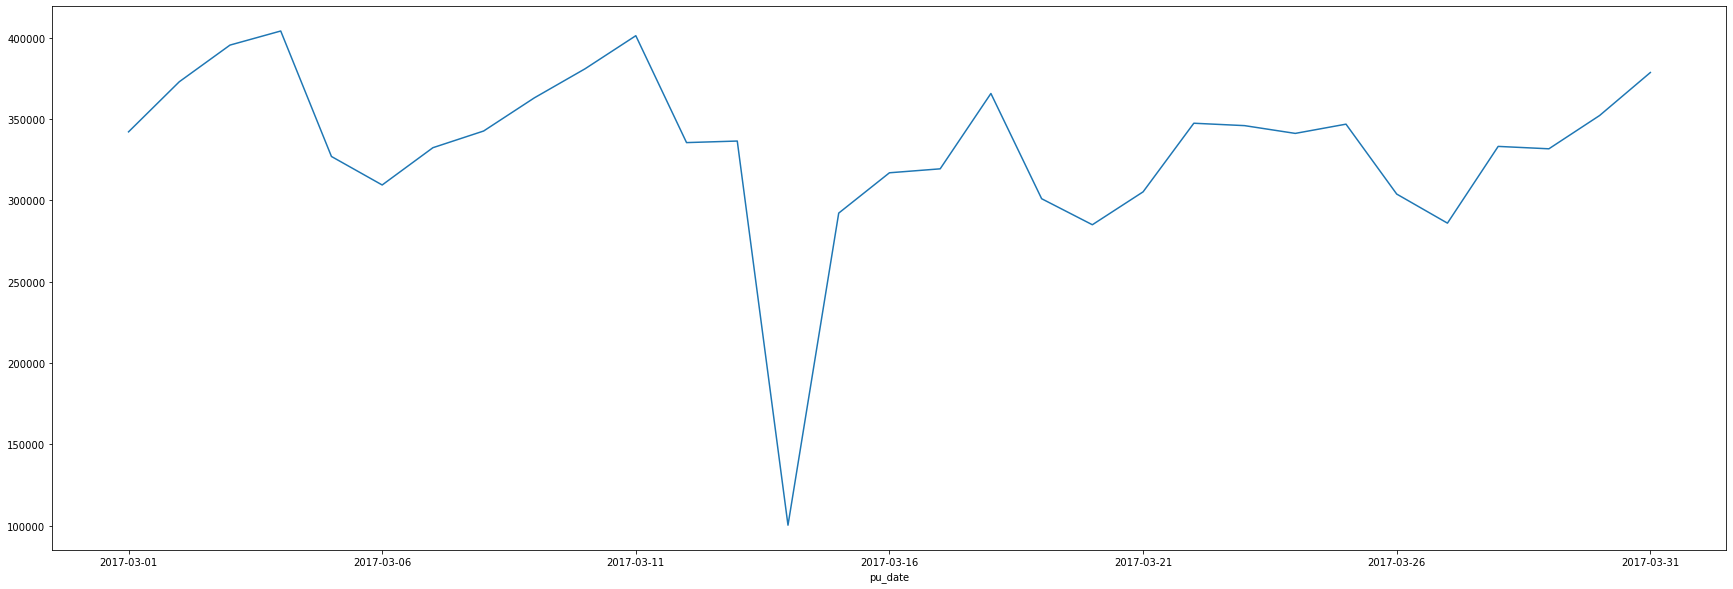

In [104]:
fig,ax = plt.subplots(figsize=(30,10))
grouped_date['tpep_pickup_datetime'].plot()


figName = "march_ts_month.png"
filePath = os.path.join(outputPath,figName)
plt.savefig(filePath)

In [79]:
grouped_date['day']=list(pd.Series(grouped_date.index).apply(lambda x: datetime.strptime(x,"%Y-%m-%d").weekday()))


In [86]:
import plotly.express as px

fig = px.line(grouped_date, y="tpep_pickup_datetime",hover_name="day")

fig.show()

In [37]:
# https://www.weather.gov/bgm/pastWinterMarch142017#:~:text=A%20Nor'easter%20moved%20up,to%2033%20inches%20of%20snow.


In [120]:
grouped_day=grouped_date.groupby(["day"])['tpep_pickup_datetime'].agg(["mean","max","min","std"]).reset_index()

grouped_day

,day,mean,max,min,std
0,0,304200.00,336424,284983,24271.970899
1,1,267748.75,333134,100325,112368.518680
2,2,331169.20,347375,292140,22558.860182
3,3,350157.80,372857,316923,21249.292193
4,4,363054.80,395404,319347,31600.807224
5,5,379425.00,404061,346805,27887.912806
6,6,316806.00,335470,300980,17028.117375


In [100]:

fig = px.line(grouped_day, y=grouped_day.columns[1:])
fig.show()

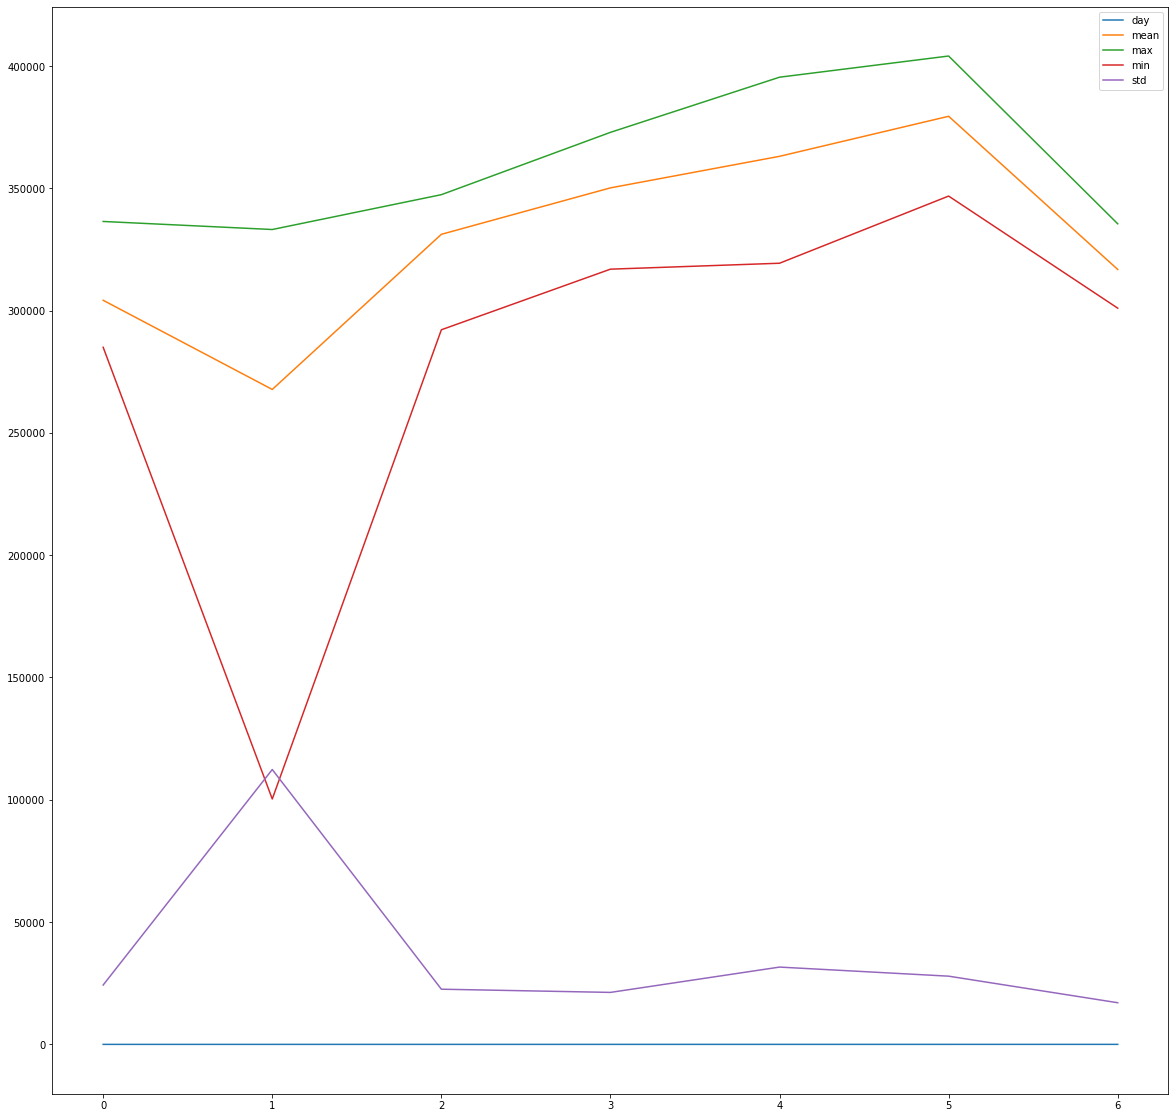

In [113]:
fig, ax = plt.subplots(figsize=(20,20))

ax.plot(grouped_day)
ax.legend(grouped_day.columns);


In [103]:
#will remove the day of the storm 
taxi_data = taxi_data[taxi_data["pu_day"]!=14]

##### Payment type


#### Payment Methods

##### Tip amount


In [115]:
taxi_data['tip_amount'].describe().round()

count    10294628.0
mean            2.0
std             3.0
min           -91.0
25%             0.0
50%             1.0
75%             2.0
max           425.0
Name: tip_amount, dtype: float64

In [116]:
#some negative values on the tip amount want to search why..
#data dictionary doesn't mention anything relevant

neg_fare=taxi_data[taxi_data['tip_amount']<0]
neg_fare

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pu_day,pu_hour,do_day,do_hour,pu_date,do_date
102204,2,2017-03-10 19:06:37,2017-03-10 19:13:10,3,1.07,1,N,162,170,1,...,-0.08,0.0,0.3,9.67,4,19,4,19,2017-03-10,2017-03-10
348787,2,2017-03-11 10:21:38,2017-03-11 10:25:35,1,0.70,1,N,237,43,3,...,-1.16,0.0,-0.3,-8.91,5,10,5,10,2017-03-11,2017-03-11
414313,2,2017-03-01 07:50:11,2017-03-01 07:50:16,2,0.00,1,N,152,152,3,...,-0.66,0.0,-0.3,-3.96,2,7,2,7,2017-03-01,2017-03-01
435759,2,2017-03-01 08:52:43,2017-03-01 08:59:03,2,0.98,1,N,140,237,3,...,-9.90,0.0,-0.3,-16.70,2,8,2,8,2017-03-01,2017-03-01
520205,2,2017-03-01 13:13:05,2017-03-01 13:13:11,2,0.00,1,N,152,152,3,...,-0.66,0.0,-0.3,-3.96,2,13,2,13,2017-03-01,2017-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9484237,2,2017-03-29 16:41:35,2017-03-29 16:42:51,2,0.09,1,N,236,236,3,...,-0.96,0.0,-0.3,-5.76,2,16,2,16,2017-03-29,2017-03-29
9503505,2,2017-03-29 17:51:11,2017-03-29 17:51:25,2,0.20,1,N,41,41,3,...,-0.86,0.0,-0.3,-5.16,2,17,2,17,2017-03-29,2017-03-29
10006205,2,2017-03-31 09:18:43,2017-03-31 09:18:48,1,0.00,2,N,264,264,1,...,-15.84,0.0,-0.3,-70.59,4,9,4,9,2017-03-31,2017-03-31
10031571,2,2017-03-31 10:43:11,2017-03-31 10:43:41,1,0.00,5,N,264,263,3,...,-0.55,0.0,-0.3,-6.20,4,10,4,10,2017-03-31,2017-03-31


In [119]:
neg_fare['payment_type'].value_counts()

3    64
4     9
1     4
Name: payment_type, dtype: int64

In [17]:
## seems to be trips that were cancelled 
neg_fare['trip_distance'].describe()

count    77.000000
mean      0.181688
std       0.314924
min       0.000000
25%       0.000000
50%       0.000000
75%       0.300000
max       1.070000
Name: trip_distance, dtype: float64

In [133]:
# I will create a sample of only the non_negative
clean_df= taxi_data[taxi_data['tip_amount']>=0]

In [24]:
clean_df['tip_amount'].describe().round()

count    10294551.0
mean            2.0
std             3.0
min             0.0
25%             0.0
50%             1.0
75%             2.0
max           425.0
Name: tip_amount, dtype: float64

#### Payment Method

In [28]:
# 1= Credit card
# 2= Cash
# 3= No charge
# 4= Dispute
# 5= Unknown
# 6= Voided trip

taxi_data['payment_type'].value_counts()

1    6994148
2    3231666
3      53815
4      14999
Name: payment_type, dtype: int64

In [124]:
# since tips don't come from cash payments we will remove them for the modeling part
test=taxi_data.groupby(['payment_type'])['tip_amount'].describe()
test.reset_index()

,payment_type,count,mean,std,min,25%,50%,75%,max
0,1,6994148.0,2.733546e+00,2.777555,-15.84,1.35,2.0,3.05,425.47
1,2,3231666.0,3.094379e-07,0.000556,0.00,0.00,0.0,0.00,1.00
2,3,53815.0,-1.876800e-03,0.274805,-33.00,0.00,0.0,0.00,10.00
3,4,14999.0,-8.973932e-04,0.962247,-91.00,0.00,0.0,0.00,55.90


In [199]:
vals=list(100*(clean_df['tip_amount']/clean_df['total_amount']))

clean_df['tip_to_total_amount']=np.array(vals).astype(int)

<ipython-input-199-9064cbafc24b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([4.240235e+06, 5.072681e+06, 9.436170e+05, 2.345800e+04,
        6.257000e+03, 2.918000e+03, 1.563000e+03, 1.077000e+03,
        7.310000e+02, 5.780000e+02]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

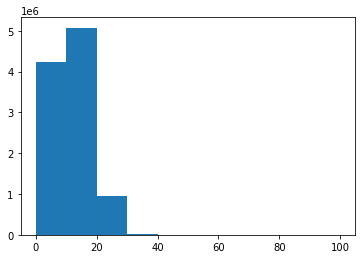

In [200]:
plt.hist(vals)

In [30]:
#will keep only the payment checks
clean_df = clean_df[clean_df['payment_type']==1]

##### Passengers


In [31]:
clean_df['passenger_count'].describe().round()

count    6994144.0
mean           2.0
std            1.0
min            0.0
25%            1.0
50%            1.0
75%            2.0
max            9.0
Name: passenger_count, dtype: float64

In [32]:
clean_df.groupby(['passenger_count'])['tip_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_count,,,,,,,,
0,486.0,3.141379,5.797620,0.0,0.00,1.135,3.6975,51.09
1,5090081.0,2.715601,2.775749,0.0,1.32,2.000,3.0000,425.47
2,970893.0,2.811780,2.820289,0.0,1.36,2.000,3.1600,258.69
3,269490.0,2.728255,2.660382,0.0,1.35,2.000,3.0600,120.00
4,116791.0,2.757673,2.701714,0.0,1.36,2.000,3.0600,106.75
5,342419.0,2.765313,2.755869,0.0,1.36,2.000,3.0800,200.00
6,203913.0,2.746891,2.825701,0.0,1.32,2.000,3.0600,413.38
7,28.0,5.989643,7.258269,0.0,0.00,1.690,14.0850,22.74
8,28.0,4.976071,6.954013,0.0,0.00,1.660,10.0000,22.82


<AxesSubplot:>

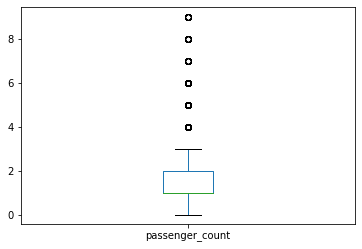

In [33]:
clean_df['passenger_count'].plot.box()

In [34]:

corr = clean_df[["tip_amount",'passenger_count',"trip_distance","total_amount"]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,tip_amount,passenger_count,trip_distance,total_amount
tip_amount,1.00,0.01,0.72,0.83
passenger_count,0.01,1.00,0.01,0.01
trip_distance,0.72,0.01,1.00,0.90
total_amount,0.83,0.01,0.90,1.00


##### Datetime Conversions

In [35]:
#convert datetimes
from datetime import datetime

date_time_cols = ["tpep_pickup_datetime","tpep_dropoff_datetime"]

for col in date_time_cols:
    clean_df[col]=clean_df[col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))


    
clean_df['pu_day']  = clean_df["tpep_pickup_datetime"].apply(lambda x: x.day)
clean_df['pu_hour'] = clean_df["tpep_pickup_datetime"].apply(lambda x: x.hour)
clean_df['do_day']  = clean_df["tpep_dropoff_datetime"].apply(lambda x: x.day)
clean_df['do_hour'] = clean_df["tpep_dropoff_datetime"].apply(lambda x: x.hour)

<ipython-input-35-084330f9c47f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[col]=clean_df[col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))


In [125]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'pu_day', 'pu_hour', 'do_day', 'do_hour', 'pu_date',
       'do_date'],
      dtype='object')

In [129]:
test_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pu_day,pu_hour,do_day,do_hour,pu_date,do_date


In [128]:
test_df = pd.DataFrame(columns=['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'pu_day', 'pu_hour', 'do_day', 'do_hour', 'pu_date',
       'do_date'])


test_df.append(taxi_data[0:10])

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pu_day,pu_hour,do_day,do_hour,pu_date,do_date
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,N,148,48,1,...,3.06,0.0,0.3,18.36,3,21,3,21,2017-03-09,2017-03-09
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,N,48,107,2,...,0.00,0.0,0.3,12.80,3,21,3,21,2017-03-09,2017-03-09
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,N,79,162,1,...,2.82,0.0,0.3,14.12,3,22,3,22,2017-03-09,2017-03-09
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,N,237,41,1,...,3.99,0.0,0.3,17.29,3,22,4,6,2017-03-09,2017-03-10
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,N,41,162,2,...,0.00,0.0,0.3,13.30,4,6,4,6,2017-03-31,2017-03-31
5,1,2017-03-01 00:00:00,2017-03-01 00:14:22,1,2.80,1,N,261,79,1,...,1.00,0.0,0.3,14.80,2,0,2,0,2017-03-01,2017-03-01
6,1,2017-03-01 00:00:00,2017-03-01 00:19:30,1,6.00,1,N,87,142,1,...,3.50,0.0,0.3,24.30,2,0,2,0,2017-03-01,2017-03-01
7,1,2017-03-01 00:00:00,2017-03-01 00:34:27,1,8.70,1,N,142,181,1,...,7.80,0.0,0.3,39.10,2,0,2,0,2017-03-01,2017-03-01
8,1,2017-03-01 00:00:00,2017-03-01 00:21:31,1,3.70,1,N,68,141,1,...,1.50,0.0,0.3,19.30,2,0,2,0,2017-03-01,2017-03-01
9,2,2017-03-15 00:07:59,2017-03-15 00:38:08,1,4.21,1,N,261,163,1,...,4.26,0.0,0.3,25.56,2,0,2,0,2017-03-15,2017-03-15


## Taxi Zones

In [130]:
#review the nyc taxi zone]
fileName = os.path.join(shpPath,"taxi_zones.shp")
taxi_zones = gpd.read_file(fileName)


<AxesSubplot:>

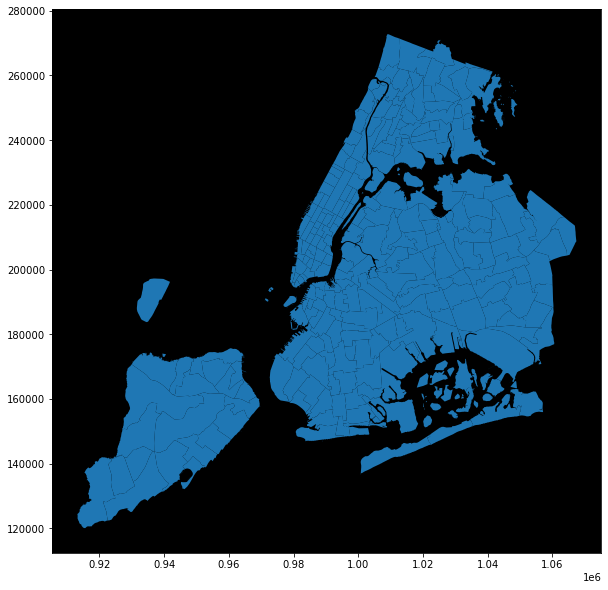

In [131]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.set_facecolor("black")
taxi_zones.plot(ax=ax)

In [134]:
#filter based tip amount - keep only positive 
column_names=["PULocationID","DOLocationID"]


for col_ in column_names:
    
    grp_=taxi_data.groupby(col_,as_index=True)['VendorID'].count()
    count_df=pd.DataFrame({"zone_id":list(grp_.index),col_:grp_})
    taxi_zones=pd.merge(taxi_zones,count_df,left_on="LocationID",right_on="zone_id")
    del taxi_zones["zone_id"]
    
    

In [146]:
taxi_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,DOLocationID,taxi_demand
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",698,19124,-18426
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",7,6,1
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",28,598,-570
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",29594,55475,-25881
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",4,55,-51
...,...,...,...,...,...,...,...,...,...,...
253,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",72,1262,-1190
254,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",6819,13526,-6707
255,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",55946,48829,7117
256,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824....",118403,125628,-7225


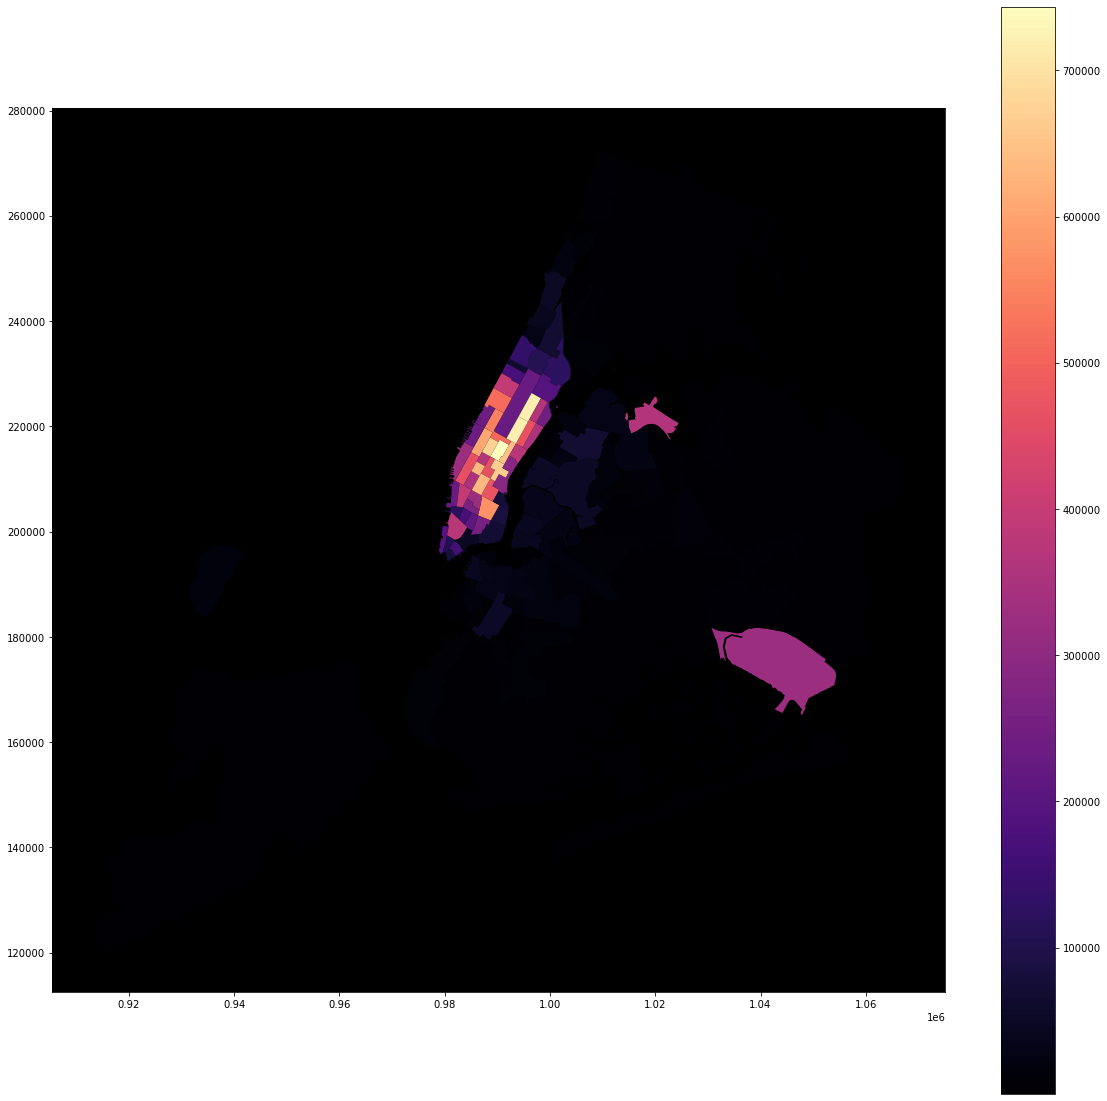

In [151]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect("equal")
ax.set_facecolor("black")
taxi_zones.plot(column='taxi_activity', cmap='magma',ax=ax,legend=True)

filePath = os.path.join(outputPath,"images","sample_spatial_count")
plt.savefig(filePath)

<AxesSubplot:>

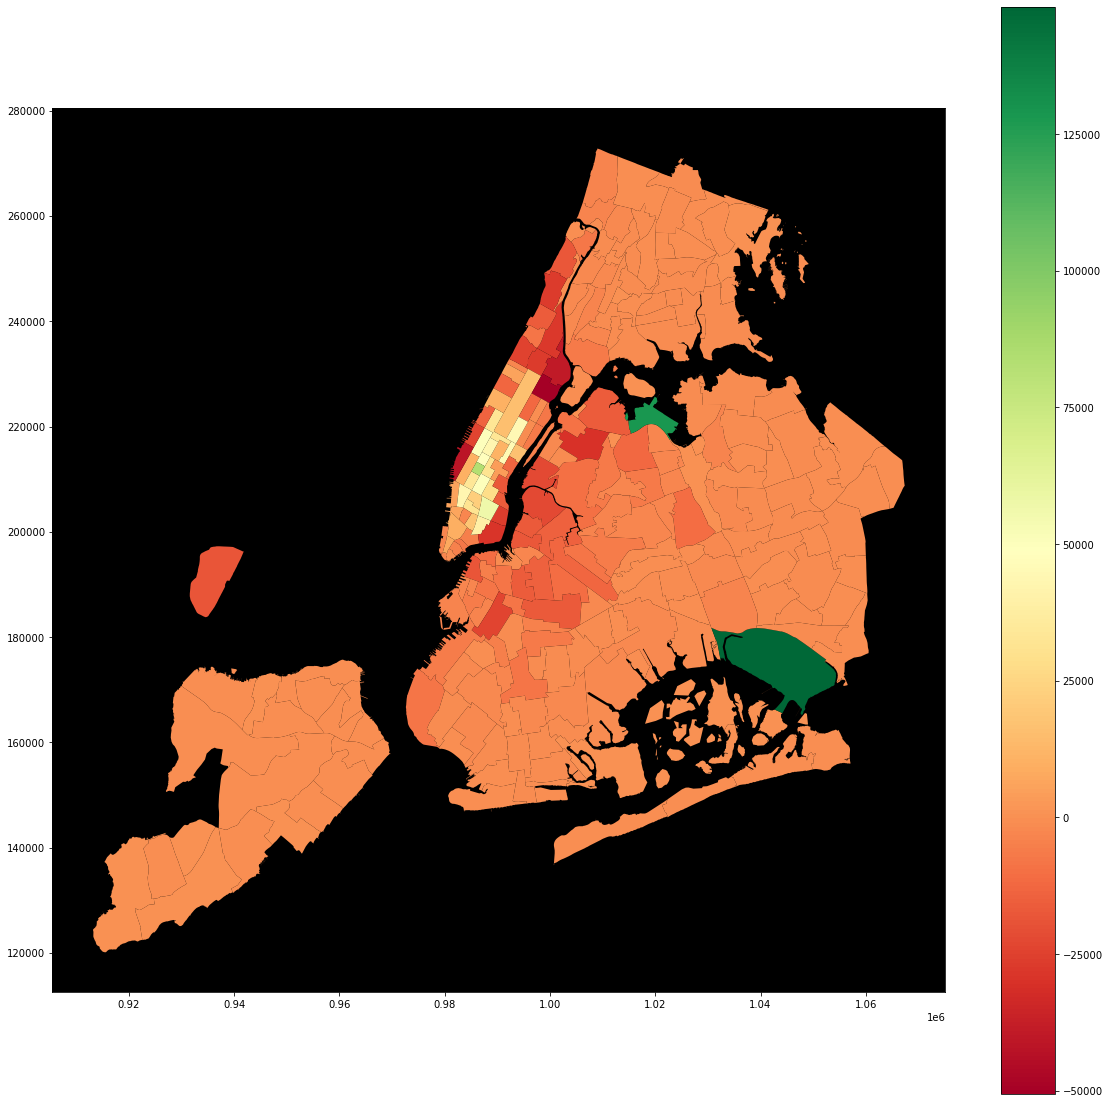

In [144]:
fig,ax = plt.subplots(figsize=(20,20))
ax.set_aspect("equal")
ax.set_facecolor("black")
taxi_zones.plot(column='taxi_demand', cmap='RdYlGn',ax=ax,legend=True)


In [123]:
taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,DOLocationID,taxi_demand
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",534,15676,-15142
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",5,3,2
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",10,311,-301
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",19712,36459,-16747
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",1,38,-37


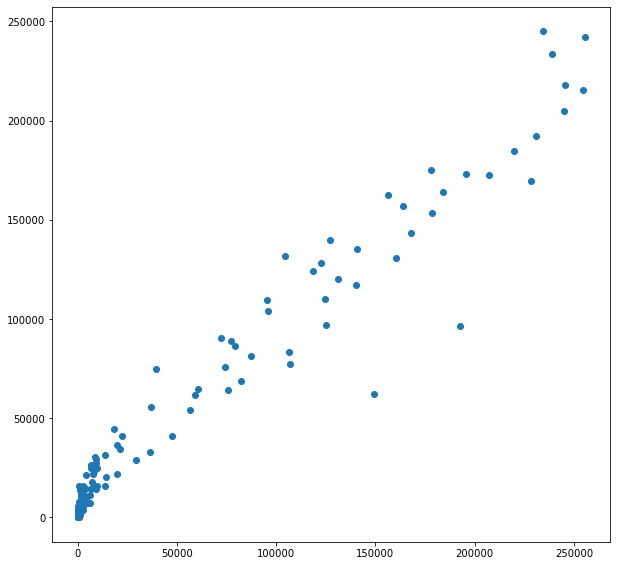

In [124]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
plt.scatter(taxi_zones['PULocationID'],taxi_zones['DOLocationID'])

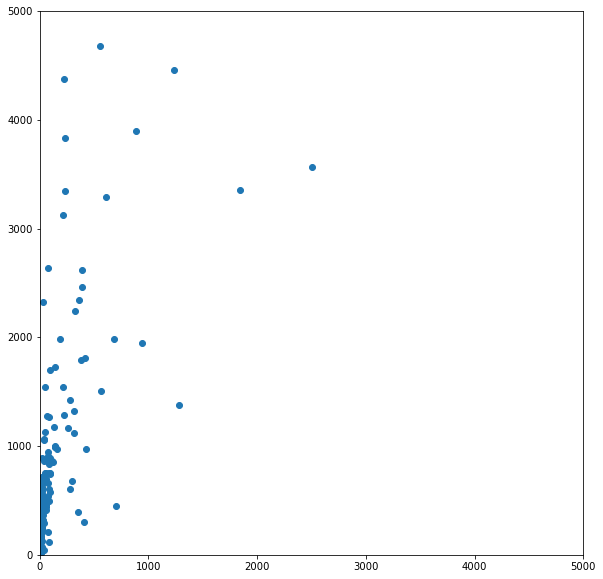

In [125]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")

ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
plt.scatter(taxi_zones['PULocationID'],taxi_zones['DOLocationID'])


In [154]:
import plotly.express as px


fig = px.scatter(taxi_zones, x="PULocationID", y="DOLocationID", text="zone",color="taxi_demand_class")

fig.add_shape(
        # Line Diagonal
            type="line",
            x0=0,
            y0=0,
            x1=600000,
            y1=600000,
            line=dict(
                color="MediumPurple",
                width=4,
                dash="dot",
            )
)



fig.update_traces(textposition='top center')



fig.update_layout(
    height=800,
    title_text='GDP and Life Expectancy (Americas, 2007)'
)

fig.show()

most people take a taki from the airpot to the city, touristic zones as Madison Sq, Theatre District might have more pickups due to their late nature of their activities, so people might go there with a public transport but when they finish their activity it might be late so they choose to take a taxi on their way back...

In [128]:
taxi_zones['taxi_demand'].describe()

count      258.000000
mean       -10.139535
std      13286.400768
min     -35588.000000
25%      -2659.250000
50%       -585.500000
75%       -123.500000
max      96115.000000
Name: taxi_demand, dtype: float64

<AxesSubplot:>

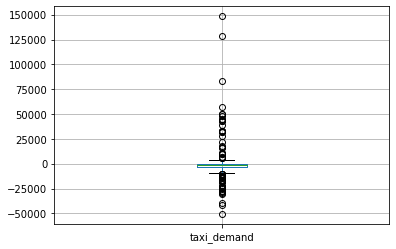

In [166]:
boxplot = taxi_zones.boxplot(column=['taxi_demand'])
boxplot

In [157]:
iqr_zones = taxi_zones[taxi_zones['taxi_demand'].between(taxi_zones['taxi_demand'].quantile(.25), taxi_zones['PULocationID'].quantile(.75), inclusive=True)]
iqr_one = taxi_zones[taxi_zones['taxi_demand'].between(taxi_zones['taxi_demand'].min(), taxi_zones['PULocationID'].quantile(.25), inclusive=True)]
iqr_last= taxi_zones[taxi_zones['taxi_demand'].between(taxi_zones['taxi_demand'].quantile(.75), taxi_zones['PULocationID'].max(), inclusive=True)]

Text(0.5, 1.0, 'Quantile Plotting - Dropoffs')

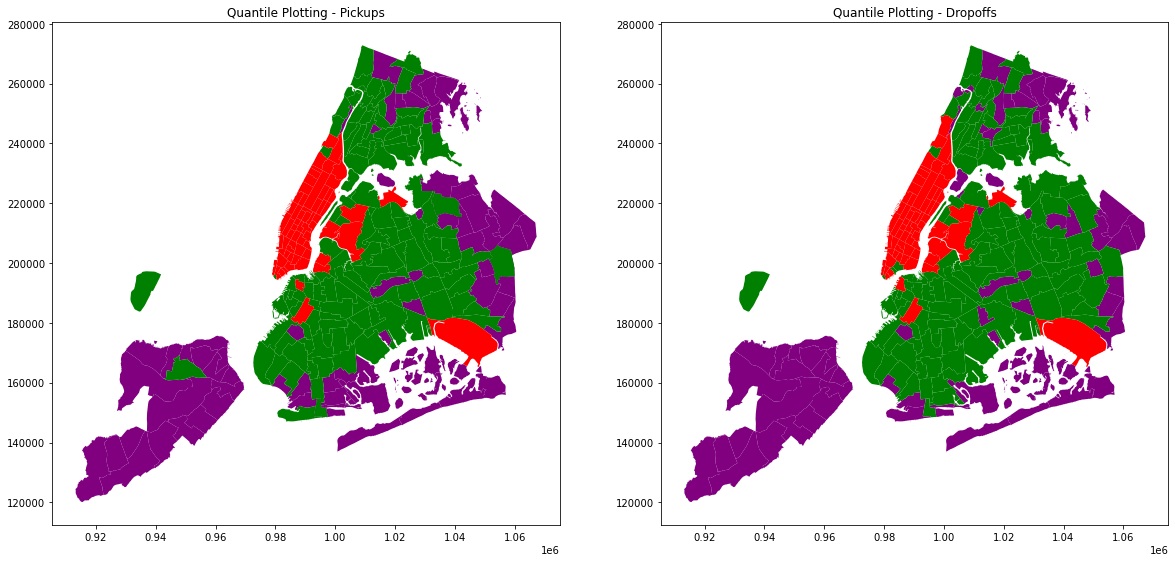

In [168]:
fig,axs= plt.subplots(1,2,figsize=(20,20))

ax=axs[0]

iqr_zones = taxi_zones[taxi_zones['PULocationID'].between(taxi_zones['PULocationID'].quantile(.25), taxi_zones['PULocationID'].quantile(.75), inclusive=True)]
iqr_one = taxi_zones[taxi_zones['PULocationID'].between(taxi_zones['PULocationID'].min(), taxi_zones['PULocationID'].quantile(.25), inclusive=True)]
iqr_last= taxi_zones[taxi_zones['PULocationID'].between(taxi_zones['PULocationID'].quantile(.75), taxi_zones['PULocationID'].max(), inclusive=True)]

iqr_one.plot(color="purple",ax=ax,label="q1",legend=True)
iqr_zones.plot(color="green",ax=ax,label="q2",legend=True)
iqr_last.plot(color="red",ax=ax,label="q3",legend=True)

ax.set_title("Quantile Plotting - Pickups")

# for idx,bound_ in enumerate(taxi_zones['geometry']):
#     geo = bound_.centroid
#     ax.annotate(text=str(taxi_zones.iloc[idx]['LocationID']),xy=[geo.x, geo.y], color="blue")
    

iqr_zones = taxi_zones[taxi_zones['DOLocationID'].between(taxi_zones['DOLocationID'].quantile(.25), taxi_zones['DOLocationID'].quantile(.75), inclusive=True)]
iqr_one = taxi_zones[taxi_zones['DOLocationID'].between(taxi_zones['DOLocationID'].min(), taxi_zones['DOLocationID'].quantile(.25), inclusive=True)]
iqr_last= taxi_zones[taxi_zones['DOLocationID'].between(taxi_zones['DOLocationID'].quantile(.75), taxi_zones['DOLocationID'].max(), inclusive=True)]
ax=axs[1]

iqr_one.plot(color="purple",ax=ax,label="q1",legend=True)
iqr_zones.plot(color="green",ax=ax,label="q2",legend=True)
iqr_last.plot(color="red",ax=ax,label="q3",legend=True)

# for idx,bound_ in enumerate(taxi_zones['geometry']):
#     geo = bound_.centroid
#     ax.annotate(text=str(taxi_zones.iloc[idx]['LocationID']),xy=[geo.x, geo.y], color="blue")
 
ax.set_title("Quantile Plotting - Dropoffs")


figName = os.path.join(outputPath,"images","quantile_plotting")
plt.savefig(figName)

#### Graph Representation

In [1]:
import networkx as nx


node_pos = []

for i in taxi_zones['geometry']:
    node_pos.append(list(i.centroid.coords)[0])
        
node_dict_pos =dict(zip(taxi_zones['LocationID'],node_pos))

G=nx.MultiDiGraph()
G.add_nodes_from(taxi_zones['LocationID'])


unique_nodes=list(taxi_zones['LocationID'].unique())
for tupple_od in list(od_tip_data.index):
    
    if((tupple_od[0] in unique_nodes) and (tupple_od[1] in unique_nodes)):
        G.add_edge(tupple_od[0],tupple_od[1])

nx.set_node_attributes(G,node_dict_pos,"pos")

NameError: name 'taxi_zones' is not defined

In [ ]:
od_tip_data=clean_df.groupby(["PULocationID","DOLocationID"])['tip_amount'].agg(['mean', 'min', 'max',"count","std"])


In [222]:

clean_df['tip_to_total_amount'].describe().astype(int)

count               10294551
mean       -1286579885312476
std       108926354947351184
min     -9223372036854775808
25%                        0
50%                       14
75%                       16
max                      100
Name: tip_to_total_amount, dtype: int64

In [224]:
min(clean_df['total_amount'])

-308.8

In [225]:
clean_df = clean_df[clean_df['total_amount']>0]

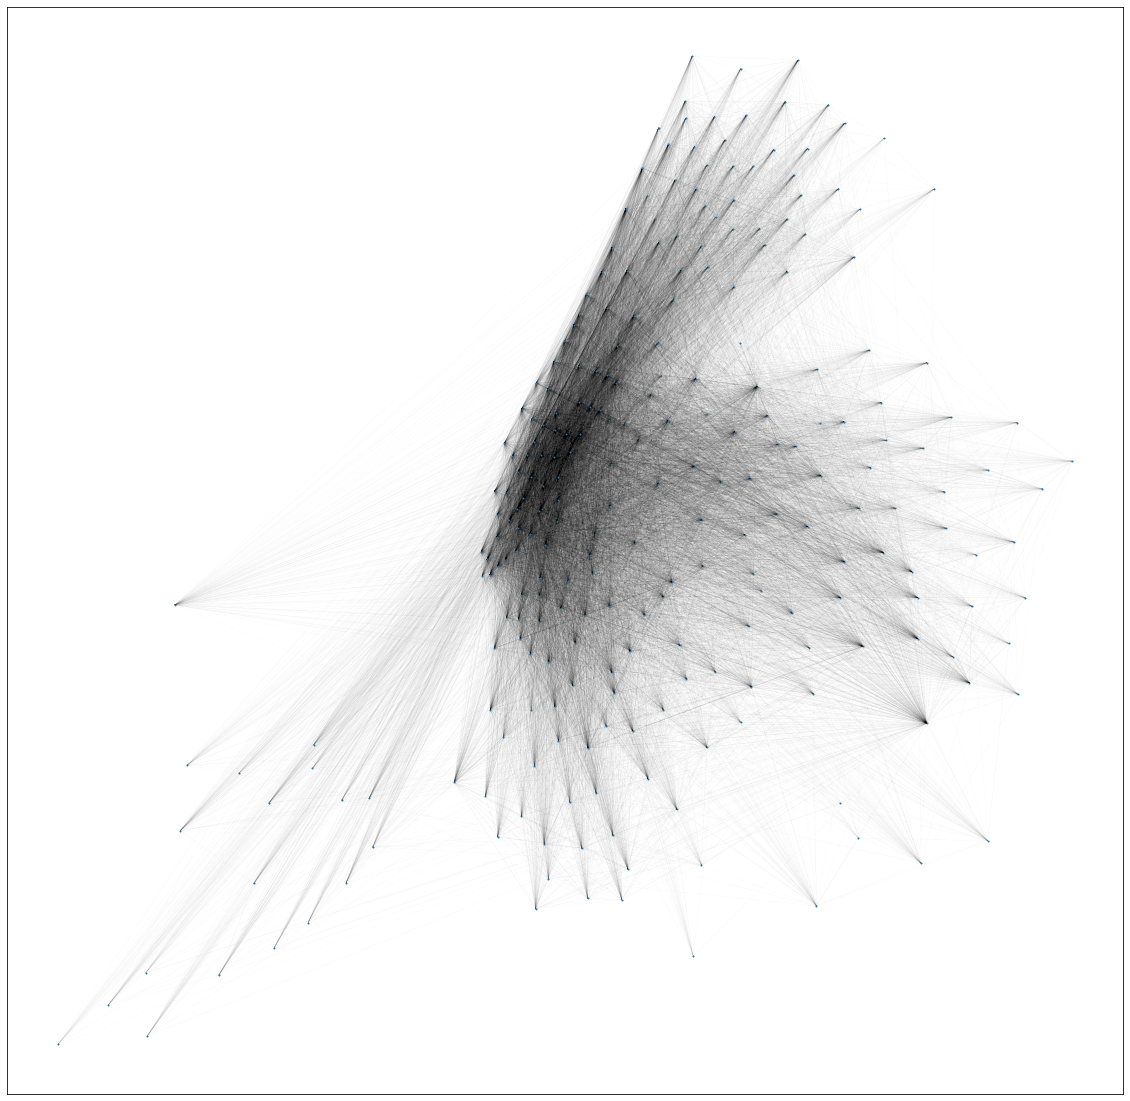

In [204]:
fig,ax = plt.subplots(figsize=(20,20))

nx.draw_networkx_nodes(G,pos=node_dict_pos,node_size=1,ax=ax)
nx.draw_networkx_edges(G,pos=node_dict_pos,arrows=False,width=0.01,ax=ax)

In [207]:
for i in list(G.edges()):
    dict_ = dict(od_tip_data.loc[i])
    G.edges[(i[0],i[1],0)]['mean']=dict_['mean']  
    G.edges[(i[0],i[1],0)]['min']=dict_['min']
    G.edges[(i[0],i[1],0)]['max']=dict_['max']
    G.edges[(i[0],i[1],0)]['count']=dict_['count']
    G.edges[(i[0],i[1],0)]['std']=dict_['std']

In [208]:
min_vals=np.array(list(nx.get_edge_attributes(G,"std").values()))

last_quantile_edges= []
count_values =[]
for edge_ in list(G.edges(data=True)):
    if (edge_[2]['count']>1000) :
        last_quantile_edges.append((edge_[0],edge_[1]))
        count_values.append(edge_[2]['std'])

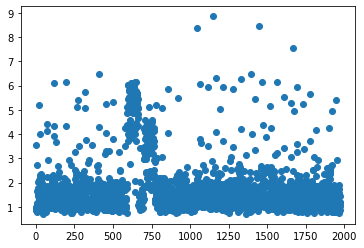

In [217]:
plt.scatter(np.arange(len(count_values)),count_values)

In [190]:
np.mean(min_vals)

307.5227752098012

In [220]:
vmax

12.59551121514747

NameError: name 'count_values' is not defined

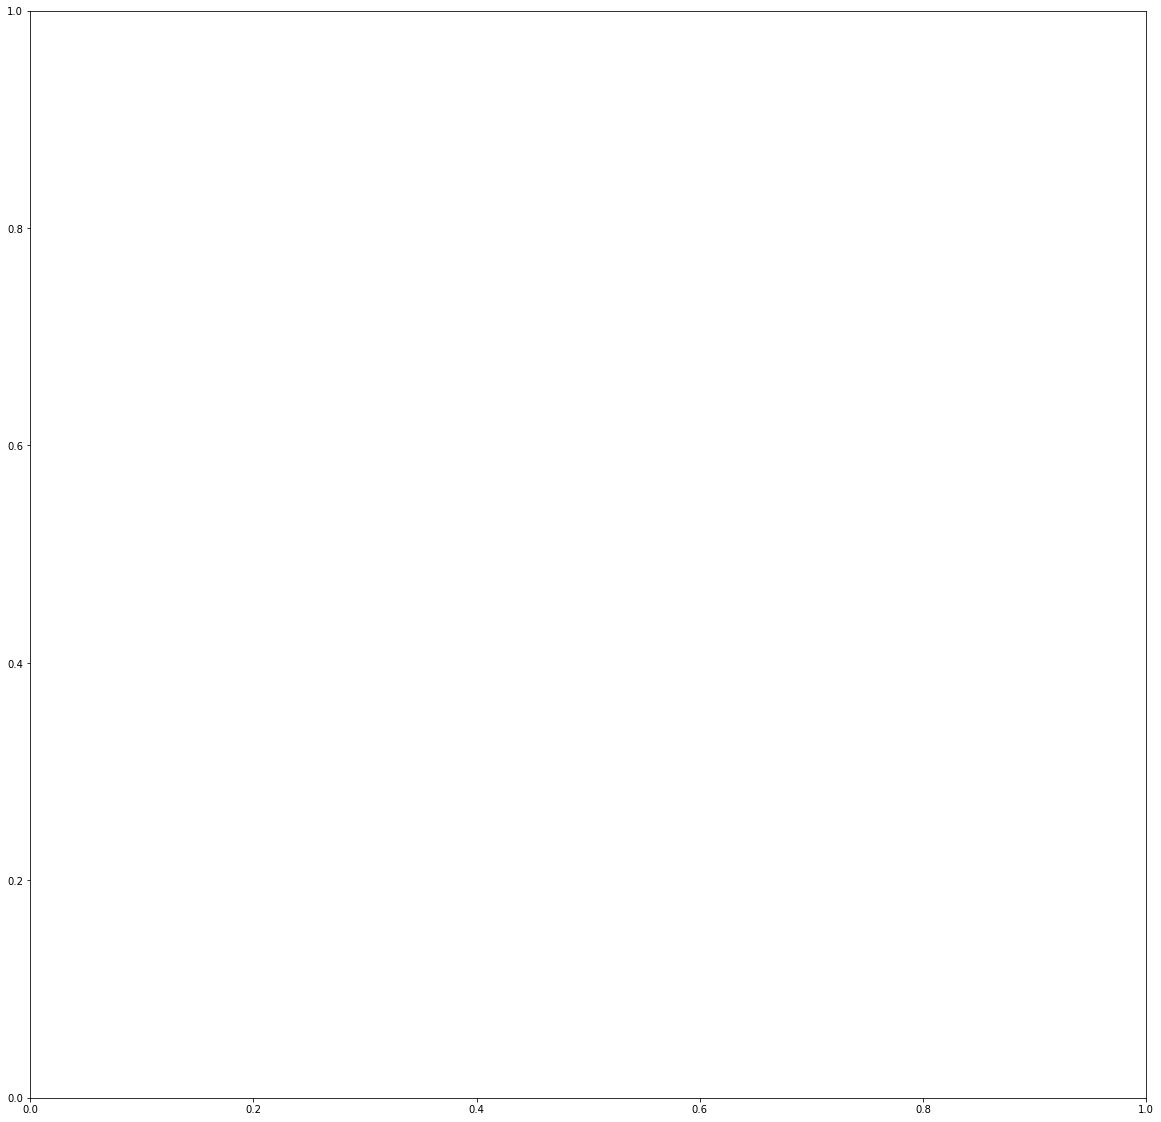

In [205]:
fig,ax = plt.subplots(figsize=(20,20))



vmin = min(count_values)
vmax = max(count_values)

nx.draw_networkx_nodes(G,pos=node_dict_pos,node_size=1,ax=ax)
nx.draw_networkx_edges(G,pos=node_dict_pos,arrows=False,width=np.array(count_values),edgelist=last_quantile_edges,
                       edge_color=count_values,alpha=0.6,edge_cmap=plt.get_cmap("magma"),edge_vmin=vmin,edge_vmax=vmax)


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("magma"), norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)


How much deviate the tip in every o-d tupple?

In [233]:
od_tip_data[od_tip_data['count']>1000]

mean  min     max   count        std
PULocationID DOLocationID                                           
4            79             1.241192  0.0   14.00    2047   0.764193
             107            1.479639  0.0   12.00    1162   0.745473
7            7              1.572114  0.0   36.80    1717   2.461002
13           13             2.116667  0.0   64.00    2133   3.261965
             48             3.452293  0.0   20.00    1801   1.562262
...                              ...  ...     ...     ...        ...
263          239            1.978659  0.0   20.00    3743   0.880850
             262            1.232320  0.0   24.95    5788   0.795800
             263            1.356164  0.0   47.82    6929   1.695794
264          264            2.683573  0.0  240.00  103312   3.068809
265          265           13.006560  0.0  345.00    3465  20.891214

[1618 rows x 5 columns]

In [235]:
for tupple_ in od_tip_data.index:
    print(tupple_)

(1, 1)
(1, 50)
(1, 65)
(1, 132)
(1, 138)
(1, 162)
(1, 170)
(1, 231)
(1, 234)
(1, 236)
(1, 237)
(1, 239)
(1, 264)
(1, 265)
(2, 55)
(2, 107)
(2, 256)
(2, 265)
(3, 3)
(3, 32)
(3, 51)
(3, 132)
(3, 185)
(3, 242)
(4, 1)
(4, 4)
(4, 7)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 21)
(4, 22)
(4, 23)
(4, 24)
(4, 25)
(4, 26)
(4, 28)
(4, 29)
(4, 33)
(4, 34)
(4, 35)
(4, 36)
(4, 37)
(4, 40)
(4, 41)
(4, 42)
(4, 43)
(4, 45)
(4, 48)
(4, 49)
(4, 50)
(4, 52)
(4, 54)
(4, 55)
(4, 56)
(4, 60)
(4, 61)
(4, 62)
(4, 63)
(4, 64)
(4, 65)
(4, 66)
(4, 67)
(4, 68)
(4, 69)
(4, 70)
(4, 71)
(4, 73)
(4, 74)
(4, 75)
(4, 76)
(4, 78)
(4, 79)
(4, 80)
(4, 81)
(4, 82)
(4, 83)
(4, 85)
(4, 87)
(4, 88)
(4, 89)
(4, 90)
(4, 92)
(4, 93)
(4, 95)
(4, 97)
(4, 98)
(4, 100)
(4, 102)
(4, 106)
(4, 107)
(4, 112)
(4, 113)
(4, 114)
(4, 116)
(4, 117)
(4, 119)
(4, 120)
(4, 121)
(4, 123)
(4, 125)
(4, 126)
(4, 127)
(4, 129)
(4, 130)
(4, 132)
(4, 133)
(4, 134)
(4, 135)
(4, 136)
(4, 137)
(4, 138)
(4, 140)
(4, 141)
(4, 142)


(50, 55)
(50, 56)
(50, 58)
(50, 60)
(50, 61)
(50, 62)
(50, 63)
(50, 64)
(50, 65)
(50, 66)
(50, 67)
(50, 68)
(50, 69)
(50, 70)
(50, 71)
(50, 72)
(50, 74)
(50, 75)
(50, 76)
(50, 77)
(50, 78)
(50, 79)
(50, 80)
(50, 81)
(50, 82)
(50, 83)
(50, 85)
(50, 87)
(50, 88)
(50, 89)
(50, 90)
(50, 91)
(50, 92)
(50, 93)
(50, 94)
(50, 95)
(50, 97)
(50, 100)
(50, 102)
(50, 105)
(50, 106)
(50, 107)
(50, 108)
(50, 112)
(50, 113)
(50, 114)
(50, 116)
(50, 119)
(50, 121)
(50, 123)
(50, 124)
(50, 125)
(50, 126)
(50, 127)
(50, 128)
(50, 129)
(50, 130)
(50, 131)
(50, 132)
(50, 133)
(50, 134)
(50, 135)
(50, 136)
(50, 137)
(50, 138)
(50, 140)
(50, 141)
(50, 142)
(50, 143)
(50, 144)
(50, 145)
(50, 146)
(50, 147)
(50, 148)
(50, 149)
(50, 150)
(50, 151)
(50, 152)
(50, 153)
(50, 155)
(50, 157)
(50, 158)
(50, 159)
(50, 160)
(50, 161)
(50, 162)
(50, 163)
(50, 164)
(50, 165)
(50, 166)
(50, 167)
(50, 168)
(50, 169)
(50, 170)
(50, 171)
(50, 172)
(50, 173)
(50, 174)
(50, 175)
(50, 177)
(50, 178)
(50, 179)
(50, 180)
(50, 18

(88, 164)
(88, 165)
(88, 166)
(88, 167)
(88, 168)
(88, 169)
(88, 170)
(88, 171)
(88, 172)
(88, 173)
(88, 174)
(88, 176)
(88, 177)
(88, 178)
(88, 179)
(88, 180)
(88, 181)
(88, 182)
(88, 185)
(88, 186)
(88, 188)
(88, 189)
(88, 190)
(88, 191)
(88, 192)
(88, 195)
(88, 196)
(88, 197)
(88, 198)
(88, 200)
(88, 201)
(88, 202)
(88, 204)
(88, 205)
(88, 206)
(88, 208)
(88, 209)
(88, 210)
(88, 211)
(88, 212)
(88, 213)
(88, 214)
(88, 215)
(88, 216)
(88, 217)
(88, 219)
(88, 220)
(88, 221)
(88, 223)
(88, 224)
(88, 225)
(88, 226)
(88, 227)
(88, 228)
(88, 229)
(88, 230)
(88, 231)
(88, 232)
(88, 233)
(88, 234)
(88, 235)
(88, 236)
(88, 237)
(88, 238)
(88, 239)
(88, 241)
(88, 242)
(88, 243)
(88, 244)
(88, 245)
(88, 246)
(88, 247)
(88, 248)
(88, 249)
(88, 250)
(88, 251)
(88, 252)
(88, 254)
(88, 255)
(88, 256)
(88, 257)
(88, 258)
(88, 259)
(88, 260)
(88, 261)
(88, 262)
(88, 263)
(88, 264)
(88, 265)
(89, 4)
(89, 7)
(89, 14)
(89, 17)
(89, 21)
(89, 22)
(89, 24)
(89, 25)
(89, 26)
(89, 29)
(89, 31)
(89, 33)
(89,

(137, 101)
(137, 102)
(137, 106)
(137, 107)
(137, 108)
(137, 112)
(137, 113)
(137, 114)
(137, 116)
(137, 118)
(137, 119)
(137, 120)
(137, 121)
(137, 122)
(137, 123)
(137, 124)
(137, 125)
(137, 126)
(137, 127)
(137, 128)
(137, 129)
(137, 130)
(137, 131)
(137, 132)
(137, 133)
(137, 134)
(137, 135)
(137, 136)
(137, 137)
(137, 138)
(137, 140)
(137, 141)
(137, 142)
(137, 143)
(137, 144)
(137, 145)
(137, 146)
(137, 147)
(137, 148)
(137, 149)
(137, 150)
(137, 151)
(137, 152)
(137, 153)
(137, 155)
(137, 156)
(137, 157)
(137, 158)
(137, 159)
(137, 160)
(137, 161)
(137, 162)
(137, 163)
(137, 164)
(137, 165)
(137, 166)
(137, 167)
(137, 168)
(137, 169)
(137, 170)
(137, 171)
(137, 173)
(137, 174)
(137, 175)
(137, 176)
(137, 177)
(137, 178)
(137, 179)
(137, 180)
(137, 181)
(137, 182)
(137, 183)
(137, 185)
(137, 186)
(137, 188)
(137, 189)
(137, 190)
(137, 191)
(137, 192)
(137, 193)
(137, 194)
(137, 195)
(137, 196)
(137, 197)
(137, 198)
(137, 200)
(137, 202)
(137, 204)
(137, 207)
(137, 208)
(137, 209)

(163, 12)
(163, 13)
(163, 14)
(163, 15)
(163, 16)
(163, 17)
(163, 18)
(163, 19)
(163, 20)
(163, 21)
(163, 22)
(163, 23)
(163, 24)
(163, 25)
(163, 26)
(163, 28)
(163, 29)
(163, 31)
(163, 32)
(163, 33)
(163, 34)
(163, 35)
(163, 36)
(163, 37)
(163, 39)
(163, 40)
(163, 41)
(163, 42)
(163, 43)
(163, 45)
(163, 46)
(163, 47)
(163, 48)
(163, 49)
(163, 50)
(163, 51)
(163, 52)
(163, 53)
(163, 54)
(163, 55)
(163, 56)
(163, 57)
(163, 58)
(163, 59)
(163, 60)
(163, 61)
(163, 62)
(163, 63)
(163, 64)
(163, 65)
(163, 66)
(163, 67)
(163, 68)
(163, 69)
(163, 70)
(163, 71)
(163, 72)
(163, 73)
(163, 74)
(163, 75)
(163, 76)
(163, 77)
(163, 78)
(163, 79)
(163, 80)
(163, 81)
(163, 82)
(163, 83)
(163, 84)
(163, 85)
(163, 87)
(163, 88)
(163, 89)
(163, 90)
(163, 91)
(163, 92)
(163, 93)
(163, 94)
(163, 95)
(163, 97)
(163, 98)
(163, 100)
(163, 101)
(163, 102)
(163, 106)
(163, 107)
(163, 108)
(163, 111)
(163, 112)
(163, 113)
(163, 114)
(163, 115)
(163, 116)
(163, 117)
(163, 119)
(163, 120)
(163, 121)
(163, 122)
(16

(209, 200)
(209, 202)
(209, 208)
(209, 209)
(209, 210)
(209, 211)
(209, 212)
(209, 214)
(209, 215)
(209, 216)
(209, 217)
(209, 218)
(209, 220)
(209, 222)
(209, 223)
(209, 224)
(209, 225)
(209, 226)
(209, 227)
(209, 228)
(209, 229)
(209, 230)
(209, 231)
(209, 232)
(209, 233)
(209, 234)
(209, 236)
(209, 237)
(209, 238)
(209, 239)
(209, 243)
(209, 244)
(209, 246)
(209, 247)
(209, 249)
(209, 250)
(209, 252)
(209, 255)
(209, 256)
(209, 257)
(209, 258)
(209, 259)
(209, 260)
(209, 261)
(209, 262)
(209, 263)
(209, 264)
(209, 265)
(210, 10)
(210, 14)
(210, 22)
(210, 55)
(210, 71)
(210, 89)
(210, 91)
(210, 123)
(210, 132)
(210, 149)
(210, 198)
(210, 210)
(210, 265)
(211, 1)
(211, 4)
(211, 6)
(211, 7)
(211, 10)
(211, 11)
(211, 12)
(211, 13)
(211, 14)
(211, 16)
(211, 17)
(211, 18)
(211, 19)
(211, 21)
(211, 22)
(211, 24)
(211, 25)
(211, 26)
(211, 28)
(211, 29)
(211, 32)
(211, 33)
(211, 34)
(211, 35)
(211, 36)
(211, 37)
(211, 39)
(211, 40)
(211, 41)
(211, 42)
(211, 43)
(211, 45)
(211, 47)
(211, 48)


(235, 154)
(235, 166)
(235, 168)
(235, 169)
(235, 174)
(235, 182)
(235, 185)
(235, 220)
(235, 229)
(235, 230)
(235, 235)
(235, 236)
(235, 238)
(235, 241)
(235, 243)
(235, 244)
(235, 247)
(235, 262)
(235, 263)
(235, 265)
(236, 1)
(236, 3)
(236, 4)
(236, 7)
(236, 8)
(236, 9)
(236, 10)
(236, 12)
(236, 13)
(236, 14)
(236, 15)
(236, 16)
(236, 17)
(236, 18)
(236, 19)
(236, 20)
(236, 21)
(236, 22)
(236, 23)
(236, 24)
(236, 25)
(236, 26)
(236, 28)
(236, 31)
(236, 32)
(236, 33)
(236, 34)
(236, 35)
(236, 36)
(236, 37)
(236, 39)
(236, 40)
(236, 41)
(236, 42)
(236, 43)
(236, 45)
(236, 46)
(236, 47)
(236, 48)
(236, 49)
(236, 50)
(236, 51)
(236, 52)
(236, 53)
(236, 54)
(236, 56)
(236, 57)
(236, 58)
(236, 59)
(236, 60)
(236, 61)
(236, 62)
(236, 63)
(236, 65)
(236, 66)
(236, 67)
(236, 68)
(236, 69)
(236, 70)
(236, 71)
(236, 72)
(236, 73)
(236, 74)
(236, 75)
(236, 76)
(236, 78)
(236, 79)
(236, 80)
(236, 81)
(236, 82)
(236, 83)
(236, 85)
(236, 87)
(236, 88)
(236, 89)
(236, 90)
(236, 91)
(236, 92)
(236, 

(263, 261)
(263, 262)
(263, 263)
(263, 264)
(263, 265)
(264, 1)
(264, 3)
(264, 4)
(264, 7)
(264, 9)
(264, 10)
(264, 11)
(264, 12)
(264, 13)
(264, 14)
(264, 15)
(264, 16)
(264, 17)
(264, 18)
(264, 19)
(264, 20)
(264, 21)
(264, 22)
(264, 23)
(264, 24)
(264, 25)
(264, 26)
(264, 28)
(264, 31)
(264, 32)
(264, 33)
(264, 34)
(264, 35)
(264, 36)
(264, 37)
(264, 39)
(264, 40)
(264, 41)
(264, 42)
(264, 43)
(264, 45)
(264, 47)
(264, 48)
(264, 49)
(264, 50)
(264, 51)
(264, 52)
(264, 54)
(264, 55)
(264, 56)
(264, 57)
(264, 59)
(264, 60)
(264, 61)
(264, 62)
(264, 63)
(264, 64)
(264, 65)
(264, 66)
(264, 67)
(264, 68)
(264, 69)
(264, 70)
(264, 71)
(264, 72)
(264, 74)
(264, 75)
(264, 76)
(264, 77)
(264, 78)
(264, 79)
(264, 80)
(264, 81)
(264, 82)
(264, 83)
(264, 84)
(264, 85)
(264, 86)
(264, 87)
(264, 88)
(264, 89)
(264, 90)
(264, 91)
(264, 92)
(264, 93)
(264, 95)
(264, 96)
(264, 97)
(264, 98)
(264, 100)
(264, 102)
(264, 106)
(264, 107)
(264, 108)
(264, 112)
(264, 113)
(264, 114)
(264, 115)
(264, 116)


In [236]:
from sklearn.linear_model import LinearRegression

In [262]:
zone_tupple_df=clean_df[(clean_df['PULocationID']==4) & (clean_df['DOLocationID']==79)]


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pu_day,pu_hour,do_day,do_hour
21740,2,2017-03-10 15:20:05,2017-03-10 15:26:58,1,0.74,1,N,4,79,1,...,0.0,0.5,1.36,0.0,0.3,8.16,10,15,10,15
70909,1,2017-03-10 17:53:17,2017-03-10 17:57:11,1,0.60,1,N,4,79,1,...,1.0,0.5,1.25,0.0,0.3,7.55,10,17,10,17
72861,1,2017-03-10 17:58:18,2017-03-10 18:01:07,1,0.30,1,N,4,79,1,...,1.0,0.5,0.00,0.0,0.3,5.80,10,17,10,18
74201,1,2017-03-10 18:01:12,2017-03-10 18:08:03,2,1.40,1,N,4,79,1,...,1.0,0.5,0.01,0.0,0.3,8.81,10,18,10,18
80266,2,2017-03-10 18:16:03,2017-03-10 18:20:41,5,0.75,1,N,4,79,1,...,1.0,0.5,2.04,0.0,0.3,8.84,10,18,10,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10282441,1,2017-03-31 23:22:06,2017-03-31 23:33:30,1,0.40,1,N,4,79,1,...,0.5,0.5,1.00,0.0,0.3,10.30,31,23,31,23
10287838,2,2017-03-31 23:38:39,2017-03-31 23:45:16,4,0.71,1,N,4,79,1,...,0.5,0.5,1.46,0.0,0.3,8.76,31,23,31,23
10288026,1,2017-03-31 23:39:13,2017-03-31 23:43:01,1,0.60,1,N,4,79,1,...,0.5,0.5,1.45,0.0,0.3,7.25,31,23,31,23
10288182,2,2017-03-31 23:39:43,2017-03-31 23:44:40,1,0.74,1,N,4,79,1,...,0.5,0.5,1.26,0.0,0.3,7.56,31,23,31,23


In [322]:
from sklearn.model_selection import train_test_split


data_train, data_test, labels_train, labels_test = train_test_split(taxi_data[['total_amount',"trip_distance"]],
                                                                    tax_data['tip_amount'], test_size=0.20, random_state=42)


reg = LinearRegression().fit(data_train, labels_train)


labels_pred = reg.predict(data_test)

# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error

print('Mean squared error: %.2f'% skm.mean_squared_error(labels_test, labels_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% skm.r2_score(labels_test, labels_pred))


Coefficients: 
 [0.00208783 0.3856467 ]
Mean squared error: 4.70
Coefficient of determination: 0.32


but what if  we split the models per od tupple

In [321]:
r2_scores=[]
mse_scores=[]

linear_regression_performance = {}

for tupple_ in od_tip_data.index:
    
    if((tupple_ not in list(linear_regression_performance.keys()))):
        
        zone_tupple_df=clean_df[(clean_df['PULocationID']==tupple_[0]) & (clean_df['DOLocationID']==tupple_[1])]
   
        count_ = len(zone_tupple_df)
    
        if(count_>100):
            
            
            data_train, data_test, labels_train, labels_test = train_test_split(zone_tupple_df[['total_amount',"trip_distance"]],
                                                                    zone_tupple_df['tip_amount'], test_size=0.20, random_state=42)

            
            reg = LinearRegression().fit(data_train, labels_train)
            
            labels_pred = reg.predict(data_test)
            
            mse_score=skm.mean_squared_error(labels_test, labels_pred)
            r2_score_ = skm.r2_score(labels_test, labels_pred)
    
            linear_regression_performance[tupple_]={"mse_score":mse_score,"r2_score":r2_score_}
       


In [343]:
mse_scores=[i["mse_score"] for i in list(linear_regression_performance.values())]
r2_scores=[i["r2_score"] for i in list(linear_regression_performance.values())]
labels_keys = [str(i) for i in list(linear_regression_performance.keys())]

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 1.000e+01, 5.600e+01, 4.614e+03]),
 array([-15.53420996, -13.88280806, -12.23140615, -10.58000424,
         -8.92860233,  -7.27720042,  -5.62579851,  -3.9743966 ,
         -2.3229947 ,  -0.67159279,   0.97980912]),
 <BarContainer object of 10 artists>)

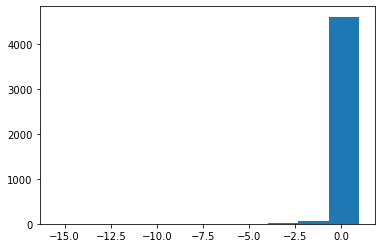

In [347]:
plt.hist(r2_scores)

In [344]:
import plotly.express as px


fig = px.scatter( x=mse_scores, y=r2_scores, text=labels_keys)

# fig.add_shape(
#         # Line Diagonal
#             type="line",
#             x0=0,
#             y0=0,
#             x1=600000,
#             y1=600000,
#             line=dict(
#                 color="MediumPurple",
#                 width=4,
#                 dash="dot",
#             )
# )



fig.update_traces(textposition='top center')



fig.update_layout(
    height=800,
    title_text='GDP and Life Expectancy (Americas, 2007)'
)

fig.show()

In [320]:
import sklearn.metrics as skm




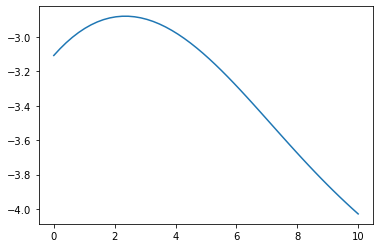

In [209]:
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = min_vals.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,10)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [210]:
from scipy.signal import argrelextrema

mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]

print("Minima:", s[mi],s[ma])



Minima: [] [2.44897959]


In [211]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',

     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',

     s[mi[1]:], e[mi[1]:], 'b',

     s[ma], e[ma], 'go',

     s[mi], e[mi], 'ro')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
march_data.groupby([])